In [33]:
import networkx as nx
from ipysigma import Sigma

In [34]:
G = nx.read_graphml("spotify_user_graph_jonas.f.rappold_1_20251027_114022.graphml")

In [35]:
G = nx.read_graphml("spotify_user_graph_jonas.f.rappold_3_20251028_010328.graphml")

In [36]:
#filter out end nodes (nodes with no outgoing edges)
def has_out_edges(node):
    return G.out_degree(node)  + G.in_degree(node) > 2

subgraph_without_endnodes = nx.subgraph_view(G, filter_node=has_out_edges)
print(f"Original graph nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")
print(f"Filtered graph nodes: {subgraph_without_endnodes.number_of_nodes()}, edges: {subgraph_without_endnodes.number_of_edges()}")

Original graph nodes: 12439, edges: 14329
Filtered graph nodes: 506, edges: 1473


In [46]:
#do a visualization with pyvis
from pyvis.network import Network

net = Network(notebook=True)
# choose which node attribute to use as visible label (change 'display_name' to your desired attribute)
label_attr = 'name'  # e.g. 'name', 'username', etc.
for n, d in subgraph_without_endnodes.nodes(data=True):
  d['label'] = d.get(label_attr) or d.get('name') or str(n)
  d['node_color'] = 'red' if d.get('error') else 'blue'
  # optional: show more info on hover
  # take a snapshot of items to avoid mutation-while-iterating issues and exclude existing label/title keys
  info_items = [f"{k}: {v}" for k, v in list(d.items()) if k not in ('label', 'title', 'follower_list')]
  d['title'] = f"{d.get('id', n)}\n" + "\n".join(info_items)

net.from_nx(subgraph_without_endnodes)



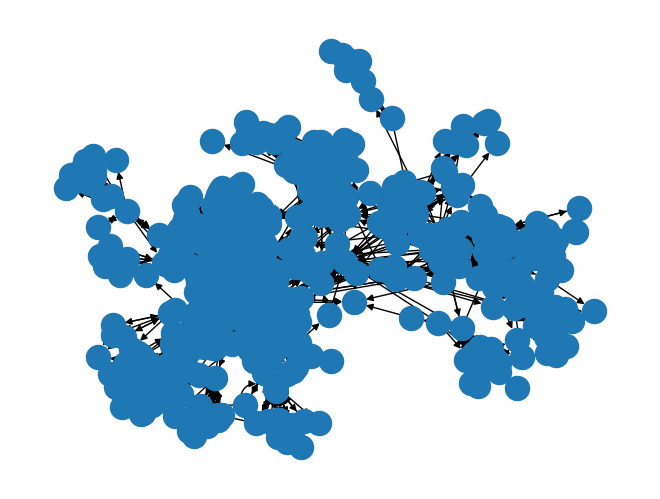

In [43]:
nx.draw(subgraph_without_endnodes)